# Basic response prediction example
In this example, the curved floating bridge created in the model creation examples is exposed to wind and wave excitation.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from wawi.model import Model, Windstate, Seastate

# Import of WAWI-model
First, the model of the simple curved floating bridge (defined in the model generation examples) is imported. Thereafter, the number of dry modes is defined together with the frequency axes of the FRF (`omega`) of the combined system and the aerodynamics (`omega_aero`).

In [14]:
# Import model
model = Model.from_wwi('./input/model_curved.wwi')
model.n_modes = 50      # define number of dry modes

# Define omega for FRF of system and aerodynamics
omega = np.arange(0.001, 2, 0.005)
omega_aero = np.arange(0.001, 2, 0.05)

## Defining `Windstate`
The wind state is defined either directly from initiation of the `Windstate` object or by importing a json file. The resulting `windstate` object is thereafter assigned to the model using the `assign_windstate` method.

In [15]:
# Define Windstate either from direct initiation of object
U0 = 20.0
direction = 90.0
windstate = Windstate(U0, direction, Iu=0.136, Iw=0.072, Au=6.8, Aw=9.4, Cuy=10.0, Cwy=6.5, Lux=115, Lwx=9.58)
# or from json
windstate = Windstate.from_json('./input/windstate_example.json')

# Assign windstate to model
model.assign_windstate(windstate)

## Defining `Seastate`
The sea state is defined either directly from initiation of the `Seastate` object or by importing a json file. The resulting `seastate` object is thereafter assigned to the model using the `assign_seastate` method.

In [16]:
# Define Seastate  (JONSWAP 1d wave spectrum and cos2s distribution) either from direct initiation of object
Hs = 2.1
Tp = 8.3
gamma = 8
s = 12
theta0 = 90.0
seastate = Seastate(Tp, Hs, gamma, theta0, s)

# or from json
seastate = Seastate.from_json('./input/seastate_example.json')

# Apply seastate to model
model.assign_seastate(seastate)

The seastate can be given inhomogeneous properties as well; see separate example for relevant descriptions. In addition to the parameters related to the one-dimensional wave spectrum (JONSWAP) and the directional distribution, you can define some options in the seastate. These are defined using an "options" key in the json-file, like shown in the example file. The "options" are defined by a dictionary, and can contain fields "truncate_theta" (define range of theta integration), "dtheta" (define step size of theta integration) and "keep_coherence" (whether or not to keep coherence). These are described more in detail in the code reference of the `Seastate` class.

## Plotting model and relevant states
Thereafter, the model and the assigned environmental states are plotted. This relies on the plotting environment used in the BEEF Python package (more details of relevant keywords can be found there).

In [17]:
# Plot model
model.plot()

Widget(value='<iframe src="http://localhost:60229/index.html?ui=P_0x2a521b2fc50_2&reconnect=auto" class="pyvis…

## Modal analysis
The defined model is used to iteratively compute the in-wind and wet modes of the bridge. The preparation of the aerodynamic stiffness and damping matrices is conducted in a separate initial step, to avoid an unnecessarily dense omega axis; this generates an interpolant that is later accessed when needing aerodynamic matrix contributions from arbitrary frequencies.

In [18]:
model.aero.prepare_aero_matrices(omega=omega_aero, aero_sections=['girder']) # optional prep step
model.run_eig(include=['hydro', 'aero'])

[ >>>>>>>>>>>>>>>>>>>> ] 101% finished with iterative modal analysis. 


Plotting a mode can be done as shown below. Also, results of the modal analysis is contained in the `results` object found in the `model` object.

In [19]:
mode_ix = 0
model.plot_mode(mode_ix)
print(f'T1 = {model.results.Tn[mode_ix]:.1f} s')
print(f'xi_1 = {model.results.xi[mode_ix]*100:.1f}%')

Widget(value='<iframe src="http://localhost:60229/index.html?ui=P_0x2a52acba850_3&reconnect=auto" class="pyvis…

T1 = 43.4 s
xi_1 = 1.0%


## Response prediction
For response prediction, the modal analysis step conducted in the previous cells is not required (note that one benefit of still doing it is that WAWI  automatically adds the frequencies corresponding to the damped natural frequencies to the FRF omega axis for a more robust analysis). The preparation step for aerodynamic matrices is repeated below for completeness (not needed if cells above are run).

In [20]:
# prepare_aero_matrices for predefined aero_sections (if not conducted, this is automatically run when using run_freqsim)
model.aero.prepare_aero_matrices(omega=omega_aero, aero_sections=['girder']) # optional prep step
model.run_freqsim(omega, print_progress=False)

### Calculate statistical response values
The way WAWI operates is to first compute the modal response (given by the dry initially-defined modes) based on the specified wave and wind excitation. Thereafter, the results can be transformed into physical quantites based on whatever modal transformation matrix definition (mode shapes) defined in the `modal_dry` object (defined as an attribute of the `model` object).

Below, we compute the response (girder forces, both expected max. and standard deviation) for all response quantities present in the modal transformation matrix (i.e., the modes). This is given by the key 'girder_forces' (it grabs the relevant dry mode shapes from the `modal_dry` object). The result is an 1d array with the response correponding to the order defined in the modal transformation matrix for the chosen key. Thereafter, the result is plotted.

In [21]:
resp_expmax = model.get_result_expmax(3600, key='girder_forces') # expected maximum
resp_std = model.get_result_std(key='girder_forces')          # standard deviation

C:\Users\knutankv\git-repos\wawi\wawi\structural.py:269: RuntimeWarning: invalid value encountered in sqrt
  v0 = 1/(2*np.pi) * np.sqrt(m2/m0)
C:\Users\knutankv\git-repos\wawi\wawi\structural.py:271: RuntimeWarning: invalid value encountered in sqrt
  expmax = peakfactor(T, v0) * np.sqrt(m0)


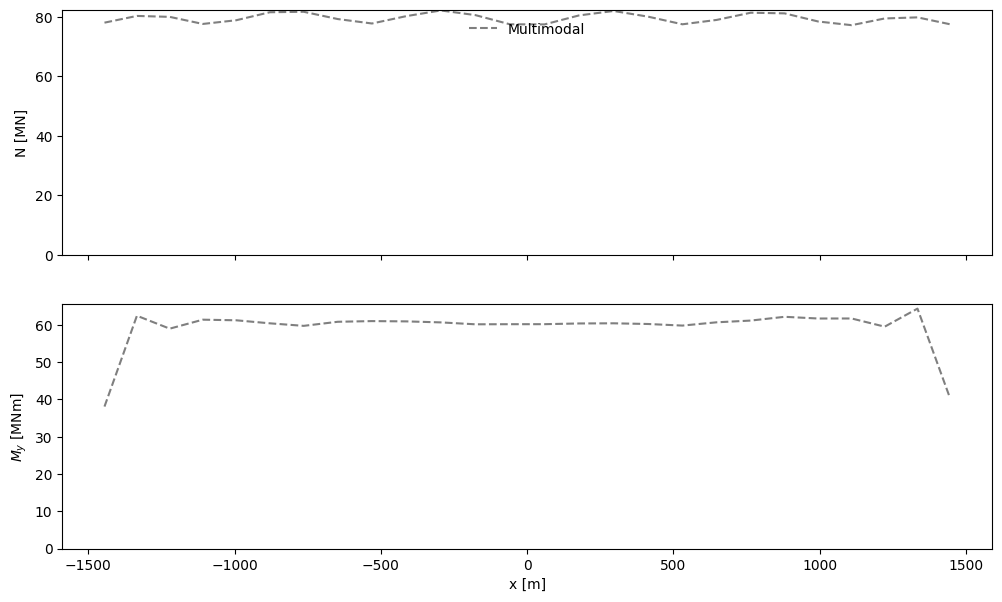

In [22]:
# Plot expected maximum
legend_ax = []
comps = {'N [MN]':0, '$M_y$ [MNm]':4}
arclength_girder_force = model.modal_dry.phi_x['girder_forces'][:, 0]

fig,ax = plt.subplots(nrows=len(comps), sharex=True, figsize=[12,7])
if np.ndim(ax)==0:
    ax = [ax]

for ix, comp in enumerate(comps):
    comp_ix = comps[comp]
    ax[ix].set_ylabel(comp)
    ax[ix].plot(arclength_girder_force, resp_expmax[comp_ix::6]/1e6, color='black', linestyle='--', alpha=0.5, label='Multimodal')
    ax[ix].set_ylim(bottom=0)
    
ax[-1].set_xlabel('x [m]')
ax[0].legend(frameon=False, loc='upper center', ncol=2)

### Response cross-spectral density matrices
Furtheremore, the cross-spectral density itself can be grabbed from the results.

The modal cross-spectral density (CPSD) is available in `model.results.S`, defined to correspond to the frequencies given in `model.results.omega`. To simplify the extraction of cross-spectral density matrices for physical quantites, a function similar to that to extract standard deviations (and expected maximum) shown above is available in WAWI, i.e., `model.get_result_psd`. This extracts a CPSD matrix based on the input key (mode shape key) and relevant indices (related to the DOFs in the defined mode shapes), as show below:

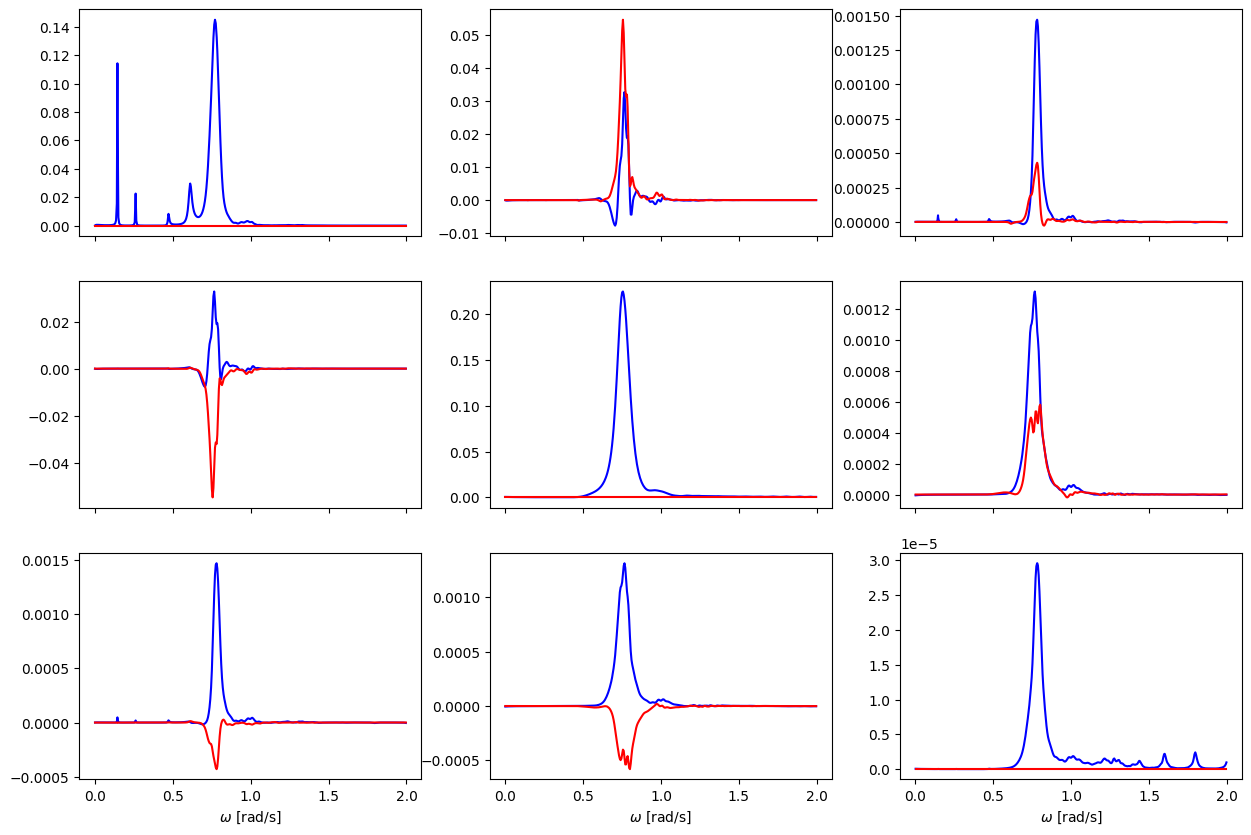

In [24]:
plot_dofs = np.array([1,2,3]) #local dofs to plot
node_ix = 50                  #index of relevant node (referring to node contained in 'full' mode shape matrix)
global_dof_ix = node_ix*6+plot_dofs

S = model.get_result_psd(key='full', 
                         index=global_dof_ix)

fig,ax = plt.subplots(nrows=S.shape[0], ncols=S.shape[1], figsize=(15,10), sharex=True)
for i in range(S.shape[0]):
    for j in range(S.shape[1]):
        ax[i,j].plot(model.results.omega, S[i,j,:].real, color='blue')
        ax[i,j].plot(model.results.omega, S[i,j,:].imag, color='red')
    
    ax[-1,i].set_xlabel('$\\omega$ [rad/s]')